In [2]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from PIL import Image

c:\Users\Jiras\Desktop\LivenessModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if CUDA is available and select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
# Load ViT model
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=5)  # 5 classes: live, 3D mask, digital, print, papercut
model.to(device)
feature_processor = ViTImageProcessor.from_pretrained(model_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# **Data Augmentation for Liveness Detection**
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping
    transforms.RandomRotation(degrees=20),  # Rotate (-20 to +20 degrees)
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Lighting changes
    transforms.RandomAffine(degrees=15, shear=10, scale=(0.9, 1.1)),  # Shear & perspective shifts
    transforms.RandomGrayscale(p=0.2),  # Convert some images to grayscale
    transforms.GaussianBlur(kernel_size=3),  # Simulate camera blur
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # Simulate occlusion
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [15]:
# Dataset directories
train_dir = 'dataset/Data/train'
val_dir = 'dataset/Data/val'

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=val_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
num_epochs = 10  # Train longer for better accuracy
for epoch in range(num_epochs):
    ####### TRAINING PHASE #######
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU
        
        optimizer.zero_grad()
        outputs = model(images).logits  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Training accuracy calculation
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    ####### VALIDATION PHASE #######
    model.eval()  # Set model to evaluation mode (turns off dropout, batch norm, etc.)
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)  # Compute validation loss

            # Validation accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

print("Training complete!")


Epoch 1/10 | Train Loss: 0.1079 | Train Accuracy: 0.9709
Epoch 1/10 | Val Loss: 0.0405 | Val Accuracy: 0.9870
Epoch 2/10 | Train Loss: 0.0268 | Train Accuracy: 0.9919
Epoch 2/10 | Val Loss: 0.0316 | Val Accuracy: 0.9899
Epoch 3/10 | Train Loss: 0.0210 | Train Accuracy: 0.9935
Epoch 3/10 | Val Loss: 0.0333 | Val Accuracy: 0.9896
Epoch 4/10 | Train Loss: 0.0158 | Train Accuracy: 0.9950
Epoch 4/10 | Val Loss: 0.0477 | Val Accuracy: 0.9871
Epoch 5/10 | Train Loss: 0.0145 | Train Accuracy: 0.9955
Epoch 5/10 | Val Loss: 0.0207 | Val Accuracy: 0.9941
Epoch 6/10 | Train Loss: 0.0109 | Train Accuracy: 0.9969
Epoch 6/10 | Val Loss: 0.0145 | Val Accuracy: 0.9963
Epoch 7/10 | Train Loss: 0.0130 | Train Accuracy: 0.9961
Epoch 7/10 | Val Loss: 0.0571 | Val Accuracy: 0.9827
Epoch 8/10 | Train Loss: 0.0099 | Train Accuracy: 0.9970
Epoch 8/10 | Val Loss: 0.0421 | Val Accuracy: 0.9886
Epoch 9/10 | Train Loss: 0.0107 | Train Accuracy: 0.9965
Epoch 9/10 | Val Loss: 0.0330 | Val Accuracy: 0.9899
Epoch 10/1

In [7]:
# Save the model after training
model_save_path = 'vit_liveness_detection_modelV2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to vit_liveness_detection_modelV2.pth


In [2]:
!pip install matplotlib

In [10]:
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification

# Automatically choose device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model and set the number of output labels
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=5)

# Load the saved model weights and map to appropriate device
model.load_state_dict(torch.load('vit_liveness_detection_modelV2.pth', map_location=device))

# Set model to evaluation mode and move it to the selected device
model.eval()
model.to(device)

# Define image transformation (should match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

print(f"Model loaded successfully on {device}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully on cpu


In [ ]:
# Dataset directories
test_dir = 'dataset_test'

# Load datasets
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

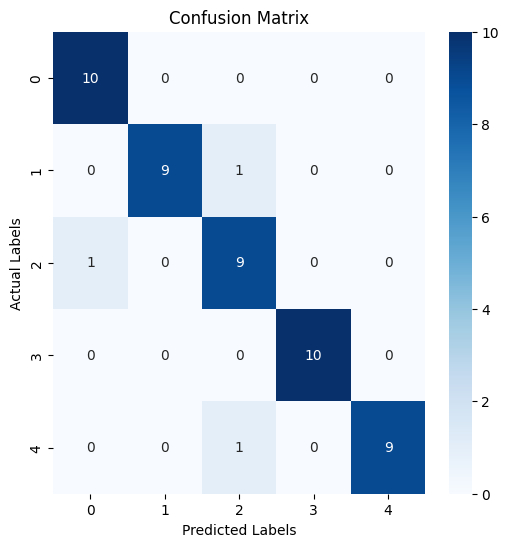

Classification Report:
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        10
           1     1.0000    0.9000    0.9474        10
           2     0.8182    0.9000    0.8571        10
           3     1.0000    1.0000    1.0000        10
           4     1.0000    0.9000    0.9474        10

    accuracy                         0.9400        50
   macro avg     0.9455    0.9400    0.9409        50
weighted avg     0.9455    0.9400    0.9409        50

Test Loss: 0.1589 | Test Accuracy: 0.9400


In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Set model to evaluation mode
model.to(device)
model.eval()

test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

# Disable gradient computation for efficiency
with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        test_loss += loss.item()

        # Store predictions and actual labels for further analysis
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute average loss and accuracy
test_loss /= len(test_loader)
test_accuracy = correct / total

# === 1. Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

# === 2. Classification Report ===
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
